Creative Commons CC BY 4.0 Lynd Bacon & Associates, Ltd. Not warranted to be suitable for any particular purpose. (You're on your own!)

# K-Fold Cross-Validation for Regression

In the following we're going to apply the _K-fold cross-validation_ method to assess model performance on data that the model "hasn't seen."

## Preliminaries

Let's first do some set-ups, and get some packages we're going to need.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn import linear_model  # OLS 
from sklearn.metrics import mean_squared_error, r2_score, SCORERS # Basic metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate, cross_val_predict

# Data Input and Preprocessing

Let's get the patient satisfaction data in the file `DECART-patSat.csv` into a Pandas DataFrame, and then extract into a numpy array the data we want to use.

In [2]:
ptSatDF=pd.read_csv('DATA/ML/DECART-patSat.csv')
ptSatDF.columns

Index(['caseID', 'patSat', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9',
       'ptCat'],
      dtype='object')

That `ptCat` variable is categorical:

In [3]:
ptSatDF.ptCat.value_counts()

1    679
0    596
2    536
Name: ptCat, dtype: int64

## Dummy Coding, or "OneHot" Coding

To use `ptCat` in a regression model we need to code it somehow.  Let's "dummy" (zero/one) code it, omitting the first category:

In [4]:
ptSatDF[['ptCat1','ptCat2']]=pd.get_dummies(ptSatDF.ptCat,drop_first=True)
ptSatDF2=ptSatDF.drop(['ptCat','caseID'],axis=1)
ptSatDF2.columns

Index(['patSat', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'ptCat1',
       'ptCat2'],
      dtype='object')

## Effects Coding of Categorical Predictor Variables Digression

If we wanted _effects_ coding of `ptCat` instead of dummy coding, we could just dummy code first, omitting the reference category, and then replace every pair of zeros with a pair of -1's.   

See if the following works to do this for you, or if it produces unexpected results.

In [5]:
ptCat=ptSatDF.ptCat.to_numpy()   # select the ptCat col
pcEC=pd.get_dummies(ptCat,drop_first=True)
rowTot=pcEC.apply(sum,axis=1)  # calc row totals
a=-1
pcEC.loc[rowTot==0]=a
pcEC.drop_duplicates()

,1,2
0,255,255
1,0,1
3,1,0


## Creating numpy Arrays for CV Training and Testing

Let's now make the numpy objects we're going to feed into our regression model.

In [6]:
ptSatX=ptSatDF2.iloc[:,1:].to_numpy()  # predictor vars
ptSatY=ptSatDF2.iloc[:,0].to_numpy()   # pt satisfaction dep var
ptSatX.shape  # Just checking
ptSatY.shape
ptSatY.min()

(1811, 10)

(1811,)

1

 # A Simple Way To Do K Fold Cross-Validation

Here we do 10 fold CV, retaining fit and timing metrics

In [7]:
np.random.seed(57)

### Available Metrics

These are for a variety of "learner" model types.

In [50]:
# Here's what the available metrics are. Uncomment and exec to list them.
# sorted(SCORERS.keys())

In [8]:
regr=linear_model.LinearRegression()  # lin reg model w/ defaults
scoring=['r2','neg_mean_squared_error','explained_variance'] # list of metrics to be returned
scores = cross_validate(regr, ptSatX, ptSatY, cv=10,
                               scoring=scoring,
                       return_train_score=True)

`scores` should be a python dict.  We can make it easier to inspect by making a DataFrame using it.

In [9]:
# type(scores)
# scores.keys()
# scores.values()
pd.DataFrame(scores)

,fit_time,score_time,test_r2,train_r2,test_neg_mean_squared_error,train_neg_mean_squared_error,test_explained_variance,train_explained_variance
0,0.001269,0.001168,0.744029,0.701565,-1.811215,-1.919569,0.744030,0.701565
1,0.000879,0.000907,0.692256,0.707983,-2.206559,-1.876766,0.692308,0.707983
2,0.000824,0.000896,0.731350,0.704014,-1.600421,-1.941993,0.731660,0.704014
3,0.000833,0.000896,0.643689,0.712851,-2.194789,-1.877032,0.649401,0.712851
4,0.001951,0.000885,0.683885,0.708667,-2.001926,-1.898538,0.684635,0.708667
5,0.001951,0.000891,0.668084,0.710313,-2.085132,-1.888684,0.672082,0.710313
6,0.001938,0.000890,0.715595,0.705548,-1.710859,-1.928804,0.716347,0.705548
7,0.001943,0.000894,0.687332,0.708571,-2.324607,-1.862466,0.687441,0.708571
8,0.001950,0.000894,0.680903,0.708593,-1.912441,-1.907681,0.680906,0.708593
9,0.001962,0.000899,0.742841,0.702754,-1.600901,-1.940552,0.743057,0.702754


Summarizing the folds' statistics:

In [11]:
pd.DataFrame(scores).describe()

,fit_time,score_time,test_r2,train_r2,test_neg_mean_squared_error,train_neg_mean_squared_error
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.001304,0.000604,0.698996,0.707086,-1.944885,-1.904209
std,0.000466,0.000144,0.033374,0.003535,0.260065,0.028104
min,0.000618,0.000323,0.643689,0.701565,-2.324607,-1.941993
25%,0.001112,0.000584,0.681648,0.704397,-2.167375,-1.926495
50%,0.001200,0.000628,0.689794,0.708277,-1.957183,-1.903110
75%,0.001415,0.000649,0.727411,0.708648,-1.735948,-1.879945
max,0.002412,0.000875,0.744029,0.712851,-1.600421,-1.862466


# Predictions From Cross-Validated Model

Predicted values for the dependent measure based on the _test_ cv folds can be obtained for Dx purposes.

In [10]:
# Predicted patient satisfaction ratings

# regrCVpreds will be a 1D array of predicted values based on test data
 
regrCVPreds=cross_val_predict(regr,ptSatX,ptSatY,cv=10,n_jobs=-1)

### Plot of Predicted Based on Test Folds vs. Actual

Note the semicolon at the end of the last line.  Remove it and run the following cell again to see what it does.

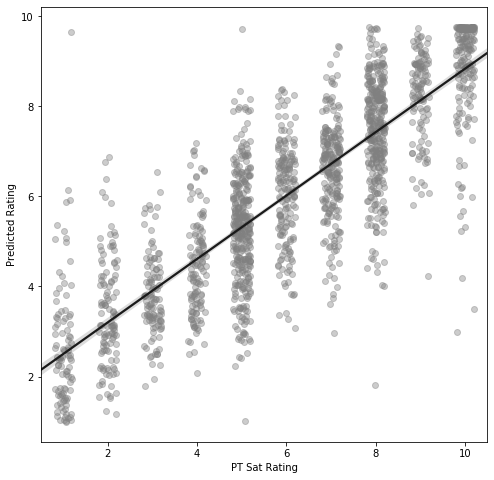

In [11]:

# points=plt.scatter(ptSatY,regrCVPreds,alpha=0.1)
plt.figure(figsize=(8,8))
plot=sns.regplot(ptSatY,regrCVPreds,
                 scatter=True,
                 color='.1',x_jitter=.2,
                 scatter_kws={"alpha":0.4,"color":"grey"})

plt.xlim(0.5,10.5)

plot=plot.set(xlabel='PT Sat Rating',ylabel='Predicted Rating');

# Another Way to Do the Kfold Shuffle

Let's use the `radon` data and try cross-validation in a slightly different way.

In [14]:
radon=pd.read_csv('DATA/radon.csv')

## Data Munging

We've seen that there is a row of data that's missing a value for the `hhincome` variable.  Let's kick that observation to the curb, and work with the rest of the data.

The following stmt selects all rows that aren't missing a value for `hhincome`, gets columns `lcanmort` through `hhincome`, and drops columns `radon`. 

In [15]:
radon2=radon.loc[radon.hhincome.notnull(),'lcanmort':'hhincome'] \
        .drop('radon',axis=1)
radon2.shape
radon2.columns

(2880, 7)

Index(['lcanmort', 'lnradon', 'obesity', 'over65', 'cursmoke', 'evrsmoke',
       'hhincome'],
      dtype='object')

## 20 Fold CV

Next will set up to do 20 fold cross-validation, pre-shuffling the data, and setting the random seed to a constant so that results can be replicated if need be.

In [16]:
kf=KFold(n_splits=20,random_state=99,shuffle=True)
X=radon2.iloc[:,1:].to_numpy()
y=radon2.loc[:,'lcanmort'].to_numpy()

cvres=list()  # This will hold cv results

regr=linear_model.LinearRegression() # define a reg model to use

for traindx, testdx in kf.split(X):  # loop over folds
    resDict={}                       # Dictionary to hold fold results
    XTrain=X[traindx]                # Xtrain
    yTrain=y[traindx]
    XTest=X[testdx]
    yTest=y[testdx]
    regModel=regr.fit(XTrain,yTrain)
    trainPred=regModel.predict(XTrain)
    trainR2=r2_score(yTrain,trainPred)
    trainMSE=mean_squared_error(yTrain,trainPred)
    testPred=regModel.predict(XTest)
    testR2=r2_score(yTest,testPred)
    testMSE=mean_squared_error(yTest,testPred)
    resDict.update({'trainR2':trainR2,
                    'testR2':testR2,
                    'trainMSE':trainMSE,
                    'testMSE':testMSE})
    cvres.append(resDict)
    

In [17]:
# Rearranging cols to make train vs test comparisons easier

cvresDF=pd.DataFrame(cvres)[['trainMSE','testMSE','trainR2','testR2']]

## Inspecting Results

Let's summarize results.

In [18]:
cvresDF.describe()

,trainMSE,testMSE,trainR2,testR2
count,20.000000,20.000000,20.000000,20.000000
mean,166.338463,167.178183,0.465881,0.458306
std,1.504895,28.563857,0.003490,0.063702
min,162.079522,126.813798,0.459364,0.333667
25%,165.744857,149.900947,0.464056,0.430661
50%,166.595322,162.365318,0.465750,0.465242
75%,167.248859,178.546491,0.467429,0.495068
max,168.463209,247.957006,0.472399,0.577696


Compare train and test metrics directly by looking at the differences betwen the within fold metrics.

In [19]:
cvresDF['TestTrainMSEDiff']=cvresDF.testMSE-cvresDF.trainMSE  # This is test-train
cvresDF['TrainTestR2Diff']=cvresDF.trainR2-cvresDF.testR2     # This is train-test

In [20]:
cvresDF[['TestTrainMSEDiff','TrainTestR2Diff']].describe()

,TestTrainMSEDiff,TrainTestR2Diff
count,20.000000,20.000000
mean,0.839720,0.007575
std,30.068707,0.067153
min,-41.649411,-0.118332
25%,-17.347912,-0.031012
50%,-4.230004,0.000309
75%,12.801634,0.036768
max,85.877483,0.137989


# UDU:  Repeat the K Fold Procedure, Above, Using the pt Sat Data